In [1]:
from matplotlib.ticker import MaxNLocator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import os
import glob
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


## Taken all features for target Emiliani2 with temporal aggregations

In [4]:
csv_with_aggreg = "./features_with_aggregations_Emiliani2.csv"
csv_target = "./csv/Emiliani2.csv"
classnames = ['VeryBad', 'Bad', 'Normal']

In [5]:
all_features = pd.read_csv(csv_with_aggreg).rename(columns={'Unnamed: 0': 'date'})

# remove the date column
features_df = all_features.iloc[:,1:]
#chosen_features_ids = [0,  1,  2,  3,  4,  9, 10, 11]
#chosen_features_df = features_df.iloc[:,chosen_features_ids]
chosen_features_df = features_df

In [6]:
# merge with target values of Emiliani2

target = pd.read_csv(csv_target).rename(columns={'Unnamed: 0': 'date'})

# remove dates not available in features
target = target[target['date'] <= all_features['date'].iloc[-1]]
target_df = pd.merge(all_features, target, on=['date'])['mean'].to_frame()

In [7]:
idx_dic = {}
for col in chosen_features_df.columns:
    idx_dic[col] = chosen_features_df.columns.get_loc(col)
print('\n'.join(f'{value}: {key}' for key, value in idx_dic.items()))

0: cyclostationary_mean_Emiliani2_tg
1: cyclostationary_mean_Emiliani2_rr
2: cyclostationary_mean_Emiliani2_tg_1w
3: cyclostationary_mean_Emiliani2_tg_4w
4: cyclostationary_mean_Emiliani2_tg_8w
5: cyclostationary_mean_Emiliani2_tg_12w
6: cyclostationary_mean_Emiliani2_tg_16w
7: cyclostationary_mean_Emiliani2_tg_24w
8: cyclostationary_mean_Emiliani2_rr_1w
9: cyclostationary_mean_Emiliani2_rr_4w
10: cyclostationary_mean_Emiliani2_rr_8w
11: cyclostationary_mean_Emiliani2_rr_12w
12: cyclostationary_mean_Emiliani2_rr_16w
13: cyclostationary_mean_Emiliani2_rr_24w


In [8]:
# divide into train/val/test sets (no data after 2019)

scaler_f = StandardScaler()
scaler_t = StandardScaler()

train_perc=0.42 # training data from 2001-01 to 2009-12 included
tot_rows = len(chosen_features_df)
# valid_perc = test_perc
valid_perc = 0.232 # validation data from 2010-01 to 2014-12 included, test until 2019-12 included

# 412 samples
features_train = chosen_features_df.iloc[0:int(tot_rows*train_perc)-1,:]
target_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]

# fit the scalers on training data
scaler_f.fit(features_train)
scaler_t.fit(target_train)

# scale all the dataset
chosen_features_df[chosen_features_df.columns] = scaler_f.transform(chosen_features_df[chosen_features_df.columns])
target_df[target_df.columns] = scaler_t.transform(target_df[target_df.columns])

features_train = chosen_features_df.iloc[0:int(tot_rows*train_perc)-1,:]
#228 samples for validation and for test
features_validation = chosen_features_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
features_test = chosen_features_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

features_train_validation = pd.concat([features_train, features_validation])

target_train = target_df.iloc[0:int(tot_rows*train_perc)-1,:]
target_validation = target_df.iloc[int(tot_rows*train_perc)-1:int(tot_rows*(valid_perc+train_perc))]
target_test = target_df.iloc[int(tot_rows*(valid_perc+train_perc)):int(tot_rows*(valid_perc*2+train_perc))]

## Compute and plot quantiles

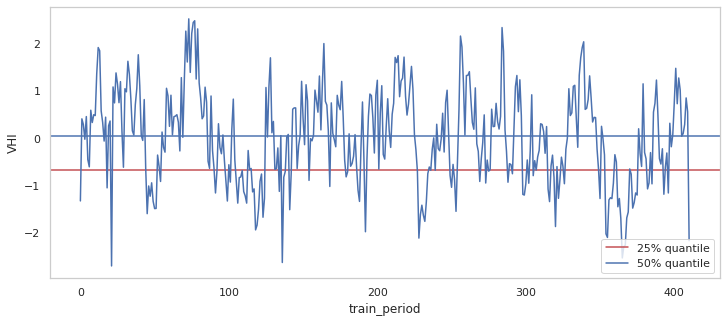

In [9]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})

y_min = target_train['mean'].quantile(0.25)
y_max = target_train['mean'].quantile(0.50)

plt.ylabel("VHI")
plt.xlabel("train_period")

plt.axhline(y_min, label='25% quantile', color = 'r')
plt.axhline(y_max, label='50% quantile')
plt.legend(loc="lower right")
plt.plot(target_train['mean'])

In [10]:
# transform the target in three classes
# 1: good, 0:bad, -1: very bad

target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
target_test['mean'] = target_test['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)

<ipython-input-10-e42b9f780ee7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_train['mean'] = target_train['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
<ipython-input-10-e42b9f780ee7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_validation['mean'] = target_validation['mean'].apply(lambda x: 1 if x > y_max else -1 if x < y_min else 0)
<ipython-input-10-e42b9f780ee7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [11]:
# ! class unbalance
np.unique(target_train['mean'], return_counts=True)

(array([-1,  0,  1]), array([103, 103, 205]))

In [12]:
# apply SMOTE to have a balanced dataset
from collections import Counter
from imblearn.over_sampling import SMOTE

print('Original dataset shape %s' % Counter(target_train['mean']))
sm = SMOTE(random_state=42)
features_train_res, target_train_res = sm.fit_resample(features_train, target_train['mean'])
print('Resampled dataset shape %s' % Counter(target_train_res))

Original dataset shape Counter({1: 205, -1: 103, 0: 103})
Resampled dataset shape Counter({-1: 205, 1: 205, 0: 205})


In [13]:
y_train = target_train_res.values
y_validation = target_validation.values
y_test = target_test.values

X_train = features_train_res.values
X_validation = features_validation.values
X_test = features_test.values

X_train_validation = pd.concat([features_train_res, features_validation]).values
y_train_validation = pd.concat([target_train_res, target_validation['mean']]).values

In [14]:
def plot_conmat(true, pred, title, ax, ffnn):
    if ffnn:
      conmat = confusion_matrix(true, pred, labels=[2,0,1])
    else:
      conmat = confusion_matrix(true, pred, labels=[-1,0,1])
    val = np.mat(conmat)

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df_cm.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    plt.rcParams["figure.figsize"] = (5,5)
    if title is not None : ax.set_title(title) 

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

log_regr = LogisticRegression(solver='lbfgs', random_state = 42)

log_regr.fit(X_train_validation, y_train_validation)
print("Logistic Regression test accuracy: ", round(log_regr.score(X_test, y_test),3))
print("Logistic Regression train accuracy: ", round(log_regr.score(X_train_validation, y_train_validation),3))

Logistic Regression test accuracy:  0.535
Logistic Regression train accuracy:  0.517


<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


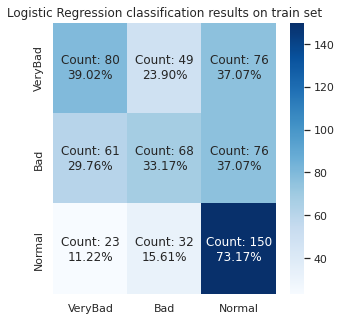

In [20]:
fig,ax=plt.subplots()
plot_conmat(y_train, log_regr.predict(X_train), 'Logistic Regression classification results on train set', ax=ax, ffnn = False)

<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


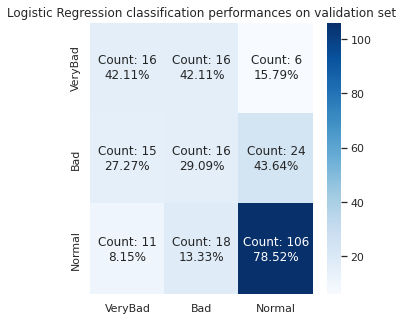

In [22]:
fig,ax=plt.subplots()
plot_conmat(y_validation, log_regr.predict(X_validation), 'Logistic Regression classification performances on validation set', ax=ax, ffnn = False)

<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


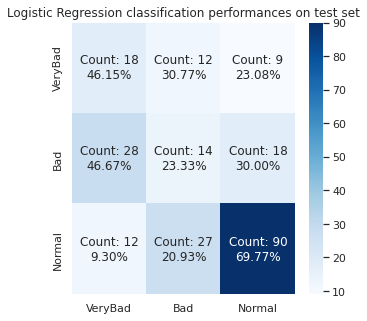

In [23]:
fig, ax = plt.subplots()
plot_conmat(y_test, log_regr.predict(X_test), 'Logistic Regression classification performances on test set', ax=ax, ffnn = False)

## Extra Trees Classifier

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 220, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 5, 10, 25, 50, 100]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               #'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }

In [ ]:
from sklearn.model_selection import GridSearchCV

# weights modified to manage unbalanced classes
#ext = ExtraTreesClassifier(random_state=42, class_weight = "balanced")
ext = ExtraTreesClassifier(random_state=42)

opt = GridSearchCV(estimator=ext, param_grid = param_grid, verbose = 3)

# GridSearchCV already does 5-fold cross validation by default,
# so I take both train and validation data
opt.fit(X_train_validation, y_train_validation.ravel())

In [ ]:
opt.best_params_

{'bootstrap': False,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 194}

In [25]:
#rfc= ExtraTreesClassifier(random_state=42, class_weight = "balanced", max_features = 'auto', min_samples_split = 2, n_estimators = 95, bootstrap = 'False')
rfc= ExtraTreesClassifier(random_state=42, max_features = 'auto', min_samples_split = 2, n_estimators = 194, bootstrap = 'False')
rfc.fit(X_train_validation, y_train_validation.ravel())

ExtraTreesClassifier(bootstrap='False', n_estimators=194, random_state=42)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_mae = mean_absolute_error(y_test, rfc.predict(X_test))
rf_mse = mean_squared_error(y_test, rfc.predict(X_test))
r2_test = rfc.score(X_test, y_test)
r2_train = rfc.score(X_train_validation, y_train_validation)

print(" ExtraTreesClassifier: ")
print(" MAE: ", round(rf_mae,3), "\n", "MSE: ", round(rf_mse,3), "\n","acc_test: ",round(r2_test,3), "\n", "acc_train: ", round(r2_train,3))

 ExtraTreesClassifier: 
 MAE:  0.504 
 MSE:  0.715 
 acc_test:  0.601 
 acc_train:  1.0


In [ ]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_list = list(chosen_features_df.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: cyclostationary_mean_Emiliani2_rr_8w Importance: 0.09
Variable: cyclostationary_mean_Emiliani2_tg Importance: 0.08
Variable: cyclostationary_mean_Emiliani2_rr_4w Importance: 0.08
Variable: cyclostationary_mean_Emiliani2_rr_12w Importance: 0.08
Variable: cyclostationary_mean_Emiliani2_tg_1w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_tg_8w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_tg_12w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_tg_16w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_tg_24w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_rr_1w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_rr_16w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_rr_24w Importance: 0.07
Variable: cyclostationary_mean_Emiliani2_rr Importance: 0.06
Variable: cyclostationary_mean_Emiliani2_tg_4w Importance: 0.06


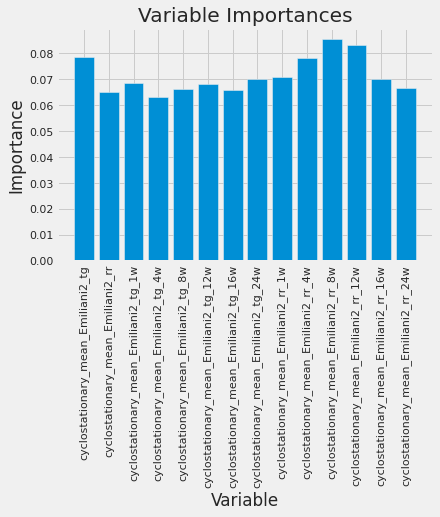

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


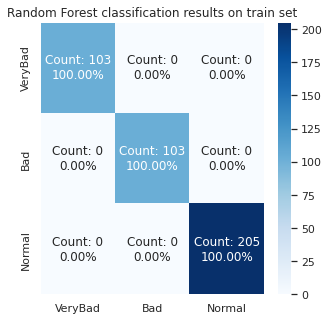

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_train, rfc.predict(X_train), 'Random Forest classification results on train set', ax=ax, ffnn=False)

<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


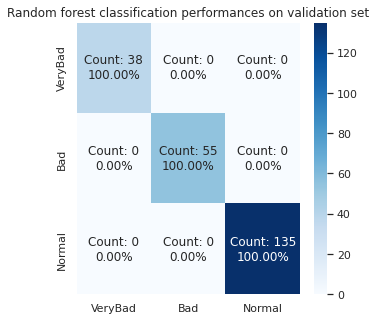

In [ ]:
fig,ax=plt.subplots()
plot_conmat(y_validation, rfc.predict(X_validation), 'Random forest classification performances on validation set', ax=ax, ffnn=False)

<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


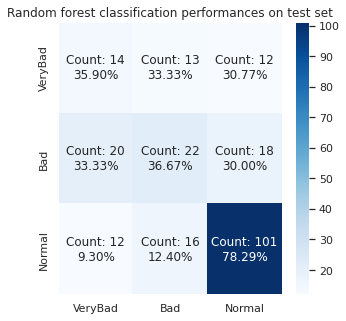

In [27]:
fig, ax = plt.subplots()
plot_conmat(y_test, rfc.predict(X_test), 'Random forest classification performances on test set', ax=ax, ffnn=False)
plt.savefig('random_forest_classification_singletask.eps', format='eps')

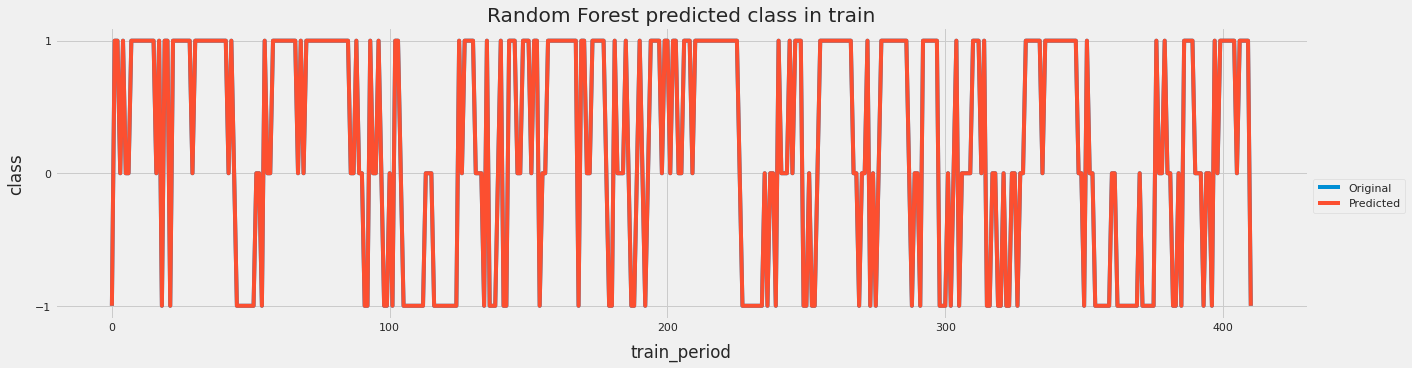

In [ ]:
fig, ax= plt.subplots()
plt.plot(y_train, label='Original')
plt.title('Random Forest predicted class in train')
plt.plot(rfc.predict(X_train), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

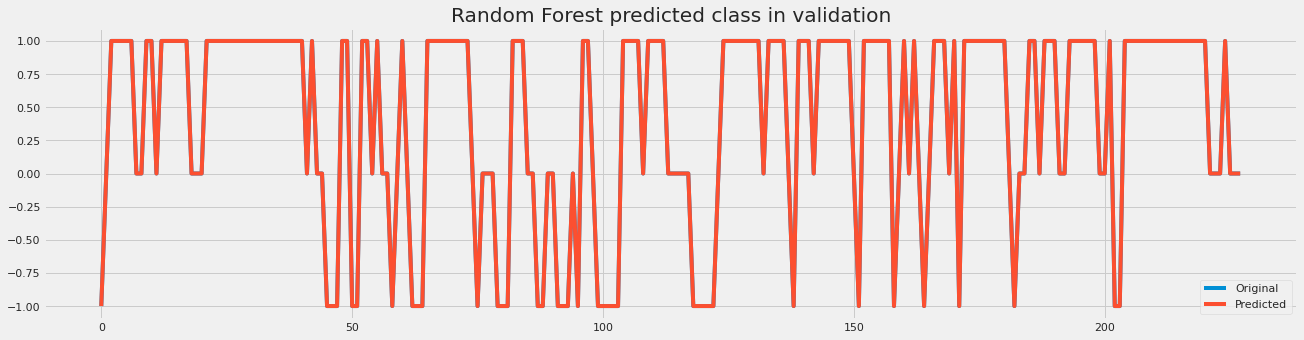

In [ ]:
plt.plot(y_validation, label='Original')
plt.title('Random Forest predicted class in validation')
plt.plot(rfc.predict(X_validation), label='Predicted')
plt.legend()
plt.show()

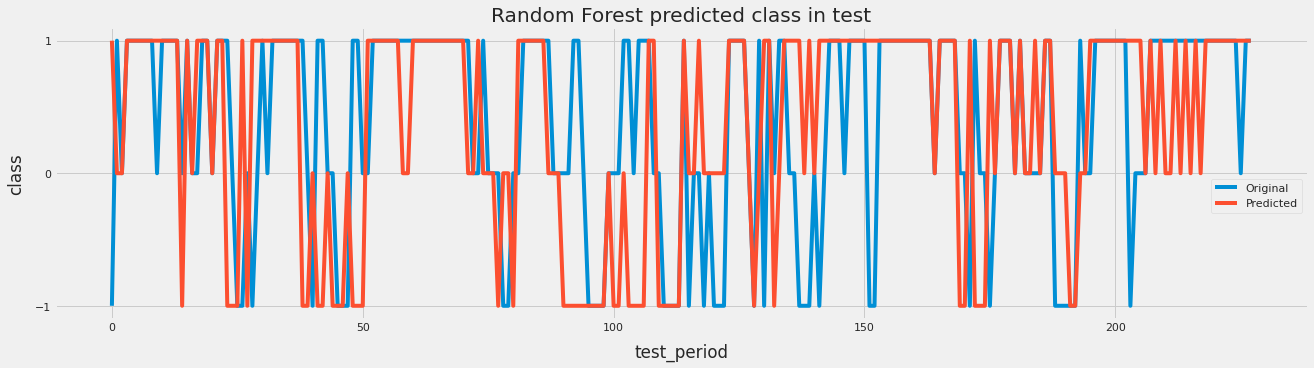

In [ ]:
fig, ax= plt.subplots()
#y_test.reset_index(inplace = True, drop = True)
plt.plot(y_test, label='Original')
plt.title('Random Forest predicted class in test')
plt.plot(rfc.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Feed Forward

In [28]:
def feed_forward():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(len(classnames), activation='softmax',name='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [29]:
# 001 for -1, 100 for 0, 010 for 1
y_train = np.eye(3)[target_train_res]
y_validation = np.eye(3)[target_validation['mean']]
y_test = np.eye(3)[target_test['mean']]

In [ ]:
from sklearn.utils import class_weight

class_weights = {0:2, 1:1, 2:2}

In [30]:
tuning_model = feed_forward()

history = tuning_model.fit(X_train, y_train, validation_data = (X_validation, y_validation), shuffle=False, epochs=1000, verbose=0)

Text(0, 0.5, 'loss')

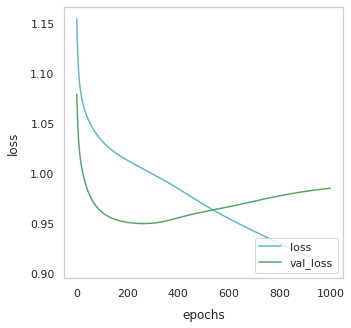

In [31]:
plt.plot(history.history['loss'], 'c', label= "loss")
plt.plot(history.history['val_loss'],'g', label= "val_loss")

plt.legend(loc="lower right")

plt.xlabel('epochs', labelpad=10)
plt.ylabel('loss', labelpad=10)

In [32]:
y_train_val = np.concatenate((y_train, y_validation))

model = feed_forward()
#tmp = model.fit(X_train_validation, y_train_val, shuffle=False, epochs=200, verbose=0, class_weight=class_weights)
tmp = model.fit(X_train_validation, y_train_val, shuffle=False, epochs=200, verbose=0)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 softmax (Dense)             (None, 3)                 15        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [33]:
print("FFNN:")
print("      ",model.metrics_names)
print("test: ", np.around(model.evaluate(X_test,y_test, verbose = 0),3))
print("train: ", np.around(model.evaluate(X_train_validation,y_train_val, verbose = 0),3))

FFNN:
       ['loss', 'accuracy']
test:  [0.943 0.509]
train:  [0.958 0.535]


20/20 [==============================] - 0s 1ms/step


<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


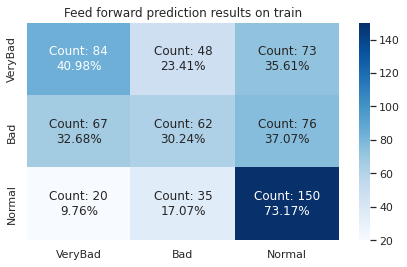

In [35]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_train.argmax(axis=1), model.predict(X_train).argmax(axis=1), 'Feed forward prediction results on train', ax=ax, ffnn = True)

8/8 [==============================] - 0s 2ms/step


<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


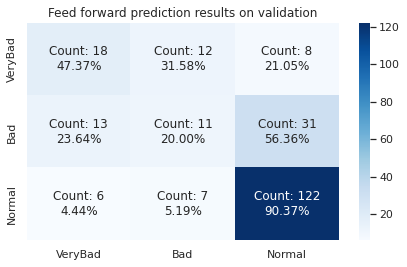

In [ ]:
fig,ax = plt.subplots(figsize=(7,4))
plot_conmat(y_validation.argmax(axis=1), model.predict(X_validation).argmax(axis=1), 'Feed forward prediction results on validation', ax=ax, ffnn = True)

8/8 [==============================] - 0s 4ms/step


<ipython-input-14-bc79a8ada8c5>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]


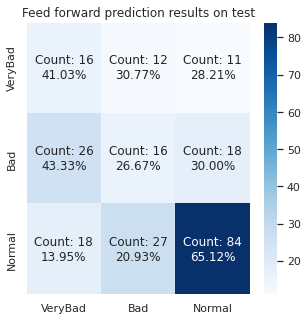

In [39]:
fig, ax = plt.subplots(figsize=(5,5))
plot_conmat(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), 'Feed forward prediction results on test', ax=ax, ffnn = True)

In [37]:
trues_test = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_test.argmax(axis=1)))
preds = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_test).argmax(axis=1)))

8/8 [==============================] - 0s 2ms/step


In [ ]:
import pickle 
with open('preds_st_ffnn.pickle', 'wb') as f: pickle.dump(preds,f)

In [ ]:
fig, ax= plt.subplots()
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_train.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_train).argmax(axis=1))), label='Predicted')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('train_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.legend()
plt.show()

8/8 [==============================] - 0s 1ms/step


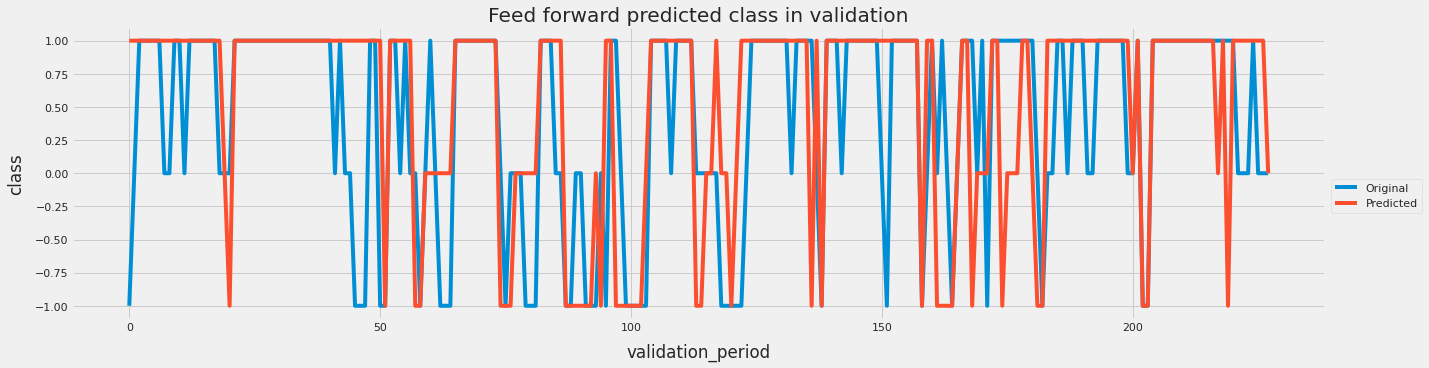

In [ ]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_validation.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in validation')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(features_validation).argmax(axis=1))), label='Predicted')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('validation_period', labelpad=10)
plt.ylabel('class', labelpad=10)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

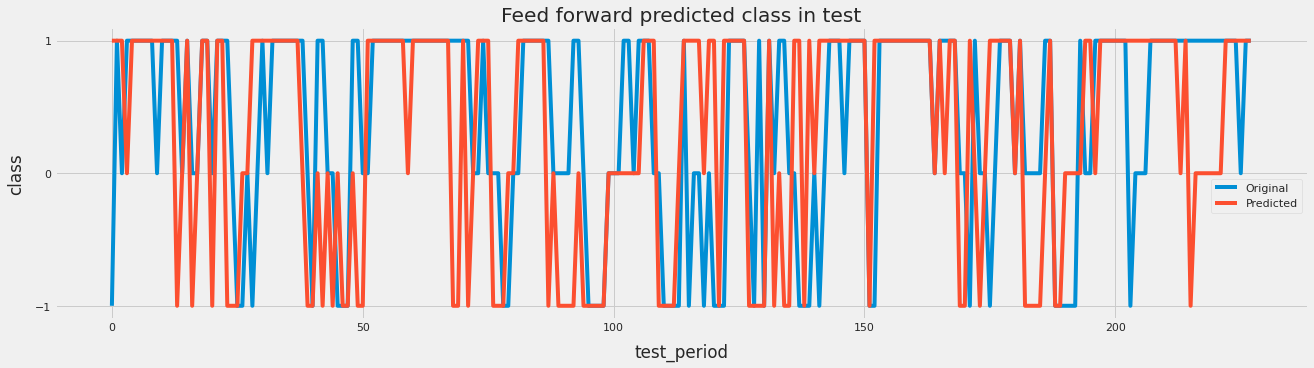

In [ ]:
fig, ax = plt.subplots()
plt.plot(trues_test, label='Original')
plt.title('Feed forward predicted class in test')
plt.plot(preds, label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('test_period', labelpad=10)
plt.ylabel('class', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.rcParams["figure.figsize"] = (20,5)
plt.show()